# sMRI Segmentation and Parcellation

---

Questions:

* How do we segment the brain into tissue classes?
* How do we further divide a tissue class into sub-components?
* How are volumetric and surface data defined?

Objectives:

* Understand and visualize tissue segementation
* Manipulate atlases to extraact regions of interests
* Visualize and interact with both volumetric and surface data

Brain segmentation and parcellation is a key step towards further analysis.

The brain can be represented via different data format (volume, surface).

Multiple python libraries are particularly useful to manipulate brain data.

## Segmentation of brain tissues

Brain anatomy is different for every individual. Brain tissues are typically divided into:

* *gray matter (GM)*, containing neuron cell bodies
* *white matter (WM)*, including neuron connection fibers wrapped in a special signal-accelerating substance called myelin (髓鞘)
* *cerebro-spinal fluid (CSF)*, a protecting fluid present mostly around the brain but also within brain cavities (脑腔) called ventricles (脑室).

Each class can inform on different aspects of the brain. Therefore it is often useful to segment the brain in these tissue components for further processing.

![GM_WM_CSF](imgs/GM_WM_CSF.png)

An important aspect to keep in mind is that aging and disease can cause tissue modifications. Common changes include a reduction in GM, as in the case of ageing and neurodegenerative diseases such as Alzheimer’s. A tumor can cause an important localized change of signal in the area most impacted by the tumor. Another example is visibly higher WM signal intensities on T2 MRI images, so called WM hyper-intensities, which can be related to vascular pathology (common in aging), or to myelin lesions characteristic of the multiple sclerosis disease.

![brain_atrophy](imgs/brain_atrophy_460px.jpg)

The analysis of preprocessed structural images then often consists in:

1. Identifying tissue classes – including pathological tissue when appropriate – and their sub-components: this is done by segmenting the MRI images, and the topic of the current episode.
2. Quantifying morphological differences: this is typically done by measuring morphological properties such as GM volume or thickness in the whole brain or within specific regions.

In this episode we will more precisely look at:

* how to segment images into tissue classes, and also also sub-regions for the case of GM
* how to visualize segmentation results both for volumetric and surface data

Common software to segment volumetric data include [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki), [SPM](https://www.fil.ion.ucl.ac.uk/spm/) and [ANTS](http://stnava.github.io/ANTs). One of the most used software to segment surface data (in addition of volumetric data) is [Freesurfer](http://surfer.nmr.mgh.harvard.edu/). In this episode, we will use the outputs generated by [smriprep](https://github.com/nipreps/smriprep)/ [fmriprep](https://github.com/nipreps/fmriprep), which are workflows relying on all these software to generate a large variety of segmentation outputs.

## Tissue Segmentation and Visualization in practice

The tissues can be differentiated according to the MRI signal intensity, however as seen in episode 2, the main magnetic field can introduce bias and create signal inhomogeneities. It is therefore important to implement bias field correction before carrying out segmentation according to tissue intensities.

Usually the T1 MRI modality is used for segmentation as it offers the best contrast between GM, WM and CSF. However, combining multiple modalities (such as T2, PD and FLAIR) can help improve the segmentation, especially in the presence of lesions.

Tissue segmentation is presented first for normal controls. Then examples of changes that can happen in disease are shown for patients having Alzheimer’s or the multiple sclerosis disease.

### In normal controls

In normal controls, the number of tissue classes is usually fixed (there are not additional classes of pathological tissue). In practice, a distribution of the intensity of the different tissue types can be obtained by loading T1 volumes with `nibabel` then plotting a slice with `matplotlib` and displaying an histogram with `seaborn` (a plotting library built on top of matplotlib).

We will use [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/) dataset in our experiments.

In [1]:
import os
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Read BIDS data with pybids package
from bids import BIDSLayout

data_dir = "local_data/AOMIC/"
bids_layout = BIDSLayout(data_dir, derivatives=True)
bids_layout

C:\Language\Miniconda3\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Language\Miniconda3\lib\site-packages\bids\layout\validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


BIDS Layout: ...n-Python\sMRI\local_data\AOMIC | Subjects: 2 | Sessions: 0 | Runs: 0

In [2]:
import nibabel as nib

sub_id = "0001" # "0002"

# T1 data
T1_file = bids_layout.get(subject=sub_id,
                          scope="derivatives",
                          datatype="anat",
                          desc="preproc",
                          extension="nii.gz",
                          return_type="filename")[0]

T1 = nib.load(T1_file)
T1_data = T1.get_fdata()
T1_affine = T1.affine

# Binary brain mask data

T1_mask_file = bids_layout.get(subject=sub_id,
                               scope="derivatives",
                               datatype="anat",
                               suffix="mask",
                               desc="brain",
                               extension="nii.gz",
                               return_type="filename")[0]

T1_mask = nib.load(T1_mask_file)
T1_mask_data = T1_mask.get_fdata()

Apply brain mask on T1 data to get only brain data. An visualize volumetric data and intensity histogram.

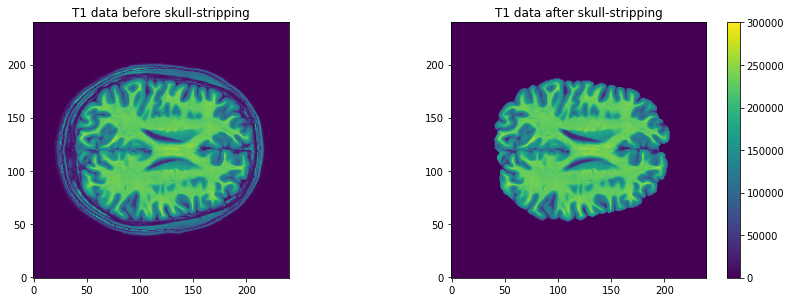

In [4]:
T1_brain_data = np.where(T1_mask_data.astype('bool'), T1_data, 0)

plt.figure(figsize=(12, 8))
n_plots = 2
n_cols = 2

plt.subplot(n_plots, n_cols, 1)
plt.imshow(T1_data[:, :, 110], vmax=300000, origin="lower")
plt.title("T1 data before skull-stripping")

plt.subplot(n_plots, n_cols, 2)
plt.imshow(T1_brain_data[:, :, 110], vmax=300000, origin="lower")
plt.title("T1 data after skull-stripping")
plt.colorbar()
plt.tight_layout()

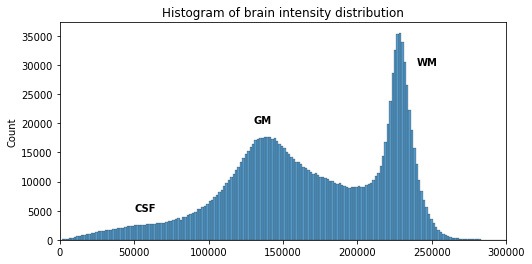

In [5]:
plt.figure(figsize=(8, 4))

# compute the optimal bin size according to the data
bins = np.histogram_bin_edges(T1_brain_data[T1_brain_data != 0], bins="auto")
# Plot the histogram
sns.histplot(T1_brain_data[T1_brain_data != 0], bins=bins)
plt.xlim([0, 300000])
plt.title('Histogram of brain intensity distribution')
plt.text(50000, 5000, "CSF", size='medium', weight='bold')
plt.text(130000, 20000, "GM", size='medium', weight='bold')
plt.text(240000, 30000, "WM", size='medium', weight='bold');

Using semgentation data to help plot the intesity distribution before skull-stripping.

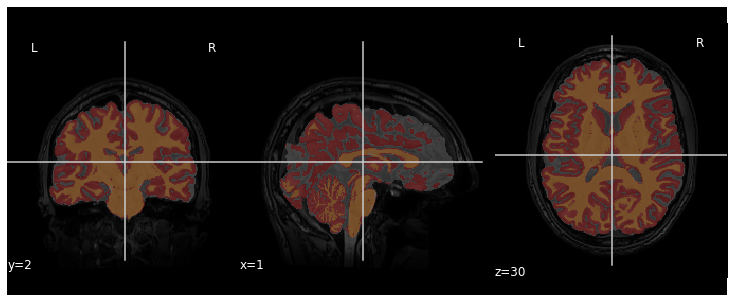

In [13]:
# Identify the right file with pybids
T1_seg_file = bids_layout.get(subject="0001",
                              scope="derivatives",
                              datatype='anat',
                              suffix='dseg',
                              extension='nii.gz',
                              return_type='filename')[2]

T1_seg = nib.load(T1_seg_file)
T1_seg_data = T1_seg.get_fdata()

fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=T1_seg, bg_img=T1, alpha=0.3, cmap="Set1", figure=fig)

Text(240000, 30000, 'WM')

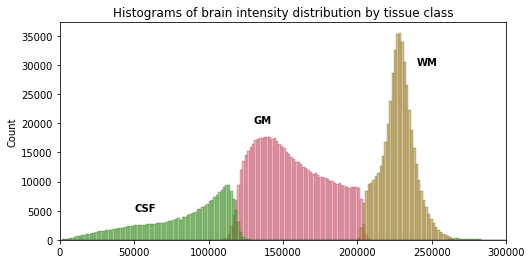

In [14]:
import itertools

labels = np.unique(T1_seg_data[T1_seg_data != 0]).astype('int')
plt.figure(figsize=(8, 4))
palette = itertools.cycle(sns.color_palette("husl"))

for label in labels:
    sns.histplot(T1_brain_data[T1_seg_data == label], bins=bins, color=next(palette), alpha=0.6)

plt.xlim([0, 300000])
plt.title('Histograms of brain intensity distribution by tissue class')
plt.text(50000, 5000, "CSF", size="medium", weight="bold")
plt.text(130000, 20000, "GM", size='medium', weight='bold')
plt.text(240000, 30000, "WM", size='medium', weight='bold')

From the shape of the histogram we can see there is some overlap between the tissue distributions. Segmentation on intensity alone is most often not enough, and additional information is required, such as the use of a template with a-priori tissue probability maps (probability of presence of a given tissue at a given location).

#### Probability map

In the previous segmentation volume, each voxel has a single integer value (1, 2 or 3) according to which tissue class it belongs. In practice however the primary output of segmentation tools are probability maps: one probability map per tissue class. In this probability map, each voxel has a value between 0 and 1 to indicate the probability to belong to that tissue class.


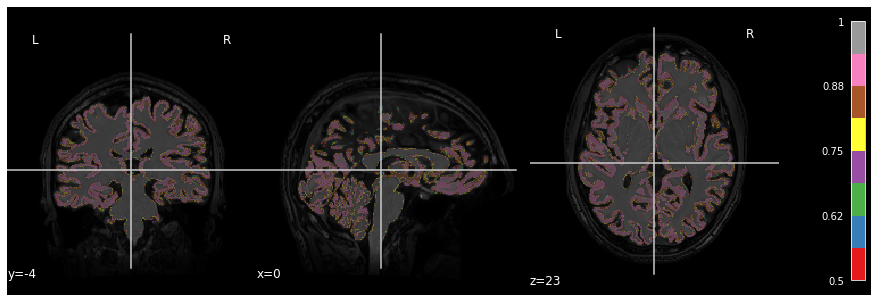

In [16]:
GM_probmap_file = bids_layout.get(subject="0001",
                                  scope="derivatives",
                                  datatype='anat',
                                  label="GM",
                                  suffix="probseg",
                                  extension='nii.gz',
                                  return_type='filename')[0]

GM_probmap = nib.load(GM_probmap_file)

fig = plt.figure(figsize=(12, 4))
plotting.plot_roi(roi_img=GM_probmap,
                  bg_img=T1,
                  alpha=0.3,
                  figure=fig,
                  colorbar=True,
                  cmap="Set1",
                  vmin=0.5,
                  vmax=1)

#### Visualize surface data

We can now have a closer look at surface data. Some software such as Freesurfer specialize in surface data. Contrarily to volumetric data which are collections of voxels, surface data are collections of vertices and faces of a mesh.

![surface](imgs/mesh.png)


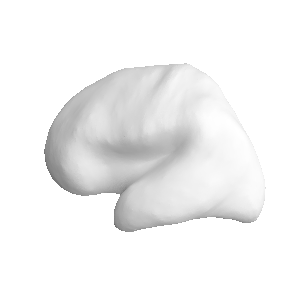

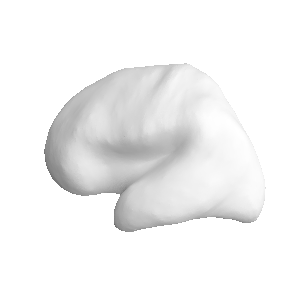

In [19]:
pial_surf_file = bids_layout.get(subject="0001",
                scope="derivatives",
                datatype='anat',
                hemi="L",  # left hemisphere
                extension='surf.gii',
                return_type='filename')[0]

pial_surf = nib.load(pial_surf_file)
pial_verts, pial_faces = pial_surf.agg_data(("pointset", "triangle"))

plotting.plot_surf((pial_verts, pial_faces))

Native Freesurfer format is more striaghtforward.

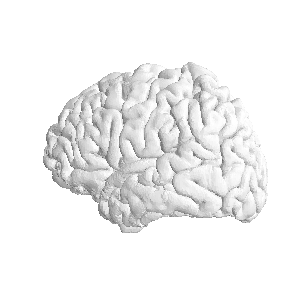

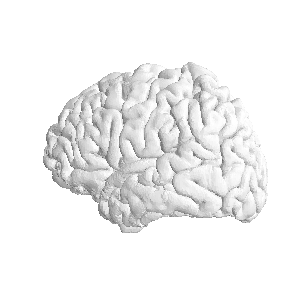

In [20]:
fs_surf_dir = "local_data/AOMIC/derivatives/freesurfer/sub-0001/surf/"
fs_pial_surf = fs_surf_dir + "lh.pial"

plotting.plot_surf(fs_pial_surf)

### In disease such as Alzheimer’s and multiple sclerosis

The brain GM volume tends to shrink with age, with the GM loss typically replaced with CSF. This process is called atrophy. In Alzheimer’s disease and other neuro-degenerative disease, atrophy is amplified (the “degeneration” is the loss of GM). Therefore special care is required when processing data of patients whose disease can cause changes in the brain morphology.

Below is a T1 image of an Alzheimer’s disease patient. An enlargement of the CSF-containing cavities, the ventricles, can be seen.

![Alzheimer's Disease](imgs/NC_vs_AD.png)

Below is a T1 and FLAIR image of an MS patient. The lesion-enhancing FLAIR modality clearly show lesions. These lesions can sometimes be seen on the T1 image. In this case they appear as dark spots called “black holes”.

![T1_VS_FLAIR](imgs/MS_T1_FLAIR_width640.png)


## Segmenting tissue classes into sub-components: atlasing, parcellation

A natural step after identifying tissue classes, is sub-dividing the tissue(s) of interest into sub-components. GM is commonly split into non-overlapping regions of interests (ROIs). This splitting process is called “parcellation” and allows to be more specific about the brain areas studied. Parcellation can be purely data-driven, anatomically-driven, or both.

In this lesson we focus on GM. WM parcellation is also common but it requires dedicated MRI sequences and analysis techniques, e.g. by identifying group of WM tracts called bundles with tractography (please refer to the lesson on diffusion MRI if you would like to know more about WM parcellation).

The usefulness of an atlas comes from the fact that each subject brain can be registered to the template on which that atlas is defined. A correct registration to the template is therefore essential for a correct labelling of the brain voxels / vertices. The template the images are registered to should also be the template on which the atlas has been defined (or highly similar).

#### Atlas vs Parcellation

A parcellation can be defined as the splitting of an object into non-overlapping components. Since an atlas divide the brain into regions, atlasing can be considered a kind of parcellation. Reciprocally, any kind of brain parcellation can be considered an “atlas”.

A difference is that an atlas is often expected to be defined on an entire brain, while a parcellation can be limited to a specific region (e.g. thalamus parcellation). A parcellation can also be applied for example to the cortical GM (the outer layer of the brain) or the subcortical GM for deep GM (GM structures below the cortex).

Note that Freesurfer call cortical parcellation “parcellation” (denoting parc the associated files) and subcortical parcellation “segmentation” (denoting seg the associated files).

The picture can be muddled when considering probabilistic atlases. In this case each atlas region is associated to a probabilistic map. Just like tissue probability maps, each voxel (or vertex) has a given probability to belong to the region considered.

### Visualizing and extracting ROIs of a non probabilistic volumetric atlas

An example of a volumetric atlas motivated by neuroanatomy is the Automated Anatomical Labeling (AAL) atlas. Each ROI has an anatomically meaningful text label. The atlas is aligned with the MNI MRI single-subject brain. The atlas is represented as a 3D volume in which each voxel has an integer index which corresponds to an ROI label, e.g. `2401` for the `left hemisphere supplementary motor area`.

`Nilearn` offers a collection of atlases in its dataset module. The AAL atlas, text labels and integer indices can all be obtained through this module.

In [22]:
nilearn_cache_dir = "local_data/nilearn_cache/"

atlas_dir = nilearn_cache_dir + 'atlases/'

from nilearn.datasets import fetch_atlas_aal

AAL_dataset = fetch_atlas_aal(data_dir=atlas_dir)
AAL_maps = AAL_dataset.maps
AAL_labels = AAL_dataset['labels']
AAL_labels_ix = AAL_dataset['indices']

We can check the atlas dimension by loading it with `nibabel`:

In [23]:
AAL_img = nib.load(AAL_maps)
AAL_img.shape

(91, 109, 91)

#### Plotting the atlas

To plot the atlas we can use as background either the template on which it was defined (or one highly similar), or a subject volume aligned with that template. In our case we use the `t1_mni` volume of our subject and use the `plot_roi` function of the nilearn plotting module to add the atlas as an overlay:



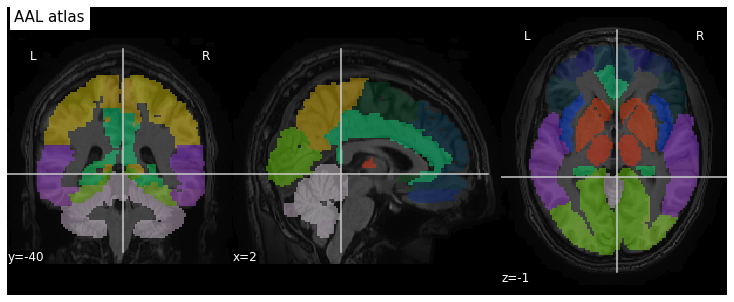

In [24]:
t1_mni_file = bids_layout.get(subject="0001",
                              scope="derivatives",
                              datatype='anat',
                              desc='preproc',
                              space='MNI152NLin2009cAsym',
                              extension='nii.gz',
                              return_type='filename')[0]

t1_mni = nib.load(t1_mni_file)
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=AAL_maps, bg_img=t1_mni, alpha=0.4, title="AAL atlas", figure=fig)

We can extract a specific ROI in two steps:
1. Identify the integer index corresponding to the ROI
2. Get all the voxels corresponding to that index

#### Indentifying an ROI integer index

Sometimes the integer index directly correspond to the label list index, e.g. if “visual cortex” is in position 3 in AAL_dataset[‘labels’] then the corresponding integer index in the image is 3. For the AAL atlas, the ROI indices are not in the order of the text labels so nilearn provide a list of ROI indices. Since the list of labels match the list of indices we proceed in two steps:

1. Find the position of the ROI in the list of AAL_labels
2. Use the same position in the list of indices

In [25]:
AAL_labels


['Precentral_L',
 'Precentral_R',
 'Frontal_Sup_L',
 'Frontal_Sup_R',
 'Frontal_Sup_Orb_L',
 'Frontal_Sup_Orb_R',
 'Frontal_Mid_L',
 'Frontal_Mid_R',
 'Frontal_Mid_Orb_L',
 'Frontal_Mid_Orb_R',
 'Frontal_Inf_Oper_L',
 'Frontal_Inf_Oper_R',
 'Frontal_Inf_Tri_L',
 'Frontal_Inf_Tri_R',
 'Frontal_Inf_Orb_L',
 'Frontal_Inf_Orb_R',
 'Rolandic_Oper_L',
 'Rolandic_Oper_R',
 'Supp_Motor_Area_L',
 'Supp_Motor_Area_R',
 'Olfactory_L',
 'Olfactory_R',
 'Frontal_Sup_Medial_L',
 'Frontal_Sup_Medial_R',
 'Frontal_Med_Orb_L',
 'Frontal_Med_Orb_R',
 'Rectus_L',
 'Rectus_R',
 'Insula_L',
 'Insula_R',
 'Cingulum_Ant_L',
 'Cingulum_Ant_R',
 'Cingulum_Mid_L',
 'Cingulum_Mid_R',
 'Cingulum_Post_L',
 'Cingulum_Post_R',
 'Hippocampus_L',
 'Hippocampus_R',
 'ParaHippocampal_L',
 'ParaHippocampal_R',
 'Amygdala_L',
 'Amygdala_R',
 'Calcarine_L',
 'Calcarine_R',
 'Cuneus_L',
 'Cuneus_R',
 'Lingual_L',
 'Lingual_R',
 'Occipital_Sup_L',
 'Occipital_Sup_R',
 'Occipital_Mid_L',
 'Occipital_Mid_R',
 'Occipital_Inf_L'

In [26]:
roi_label = "Supp_Motor_Area_L"
roi_label_pos = AAL_labels.index(roi_label)
roi_ix = int(AAL_labels_ix[roi_label_pos])
roi_ix

2401

#### Getting all voxels corresponding to that index

To create a binary ROI image from the ROI index, we:

1. Create a boolean array with True if the voxel label is equal to our ROI index, and False if not
2. Convert the boolean array to integer


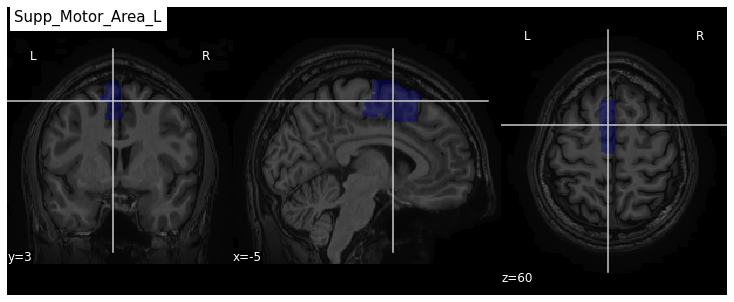

In [27]:
roi_mask_arr_bool = (AAL_img.get_fdata() == roi_ix)
roi_mask_arr = roi_mask_arr_bool.astype(int)
roi_mask = nib.Nifti1Image(roi_mask_arr, affine=AAL_img.affine)
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=roi_mask, bg_img=t1_mni, alpha=0.4, title=roi_label, figure=fig);

### Visualizing and extracting ROIs of a surface atlas

For the previous atlas, the unit elements to receive a label were voxels. When considering the surface of the cortex, unit elements are the vertices of the surface mesh. Each such vertex can receive a label, and the result is a surface parcellation.

Freesurfer relies on two surface atlases: the Desikan-Killiany Atlas with 68 ROIs and the Destrieux Atlas with 148 ROIs. The Destrieux atlas is part of the nilearn datasets and we will focus on this atlas in the lesson.

Surface datasets are split in left and right hemisphere. Let’s aim at plotting the left hemisphere. As we will see also how to plot a specific ROI, we will also extract the atlas labels.

In [29]:
from nilearn.datasets import fetch_atlas_surf_destrieux
from nilearn.datasets import fetch_surf_fsaverage

# Destrieux parcellation for left hemisphere in fsaverage5 space
destrieux = fetch_atlas_surf_destrieux(data_dir=nilearn_cache_dir)
parcellation_L = destrieux['map_left']
parcellation_R = destrieux['map_right']
destrieux_labels = destrieux['labels']


Dataset created in local_data/nilearn_cache/destrieux_surface



 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Get the mesh on which to plot the label, which will be the pial mesh of the left hemisphere for us.

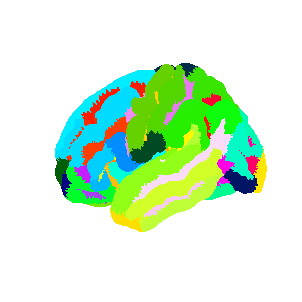

In [30]:
fsaverage = fetch_surf_fsaverage()
mesh = fsaverage['pial_left']
plotting.plot_surf_roi(mesh, roi_map=parcellation_L, hemi='left', view='lateral');

### Extracting a specific ROI

To extract a specific ROI, we can proceed as we did for the AAL atlas but using the Destrieux labels.

In [31]:
pcc_region = b'G_cingul-Post-dorsal'
roi_ix = destrieux_labels.index(pcc_region)
roi_mask_arr = (parcellation_L == roi_ix).astype(int)

To plot that ROI, we can use the `plot_surf_roi` function of the `nilearn` plotting module. We will plot the medial view since this ROI is located towards the central part of the brain. We will also use the template as background image since most vertices do not have a label to be plotted.


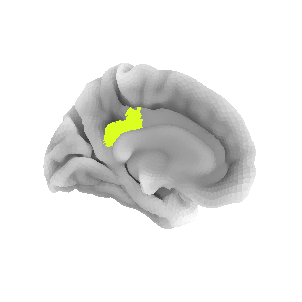

In [32]:
plotting.plot_surf_roi(mesh, roi_map=roi_mask_arr, hemi='left', view='medial',
                       bg_map=fsaverage['sulc_left']);

Because atlases can be overlaid on a subject brain registered to the atlas template, one can extract measurements specific to that subject within each atlas ROI. We will see common metrics and how to extract them in episode 6, and the important role of the WM and GM pial surfaces for this purpose.